In [8]:
import requests
import json
import csv
from bs4 import BeautifulSoup
import traceback
import cloudscraper
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
from re import sub
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#define functions 
def get_cars(
  make="BMW", 
  model="5 SERIES", 
  postcode="SW1A 0AA", 
  radius=1500, 
  min_year=1995, 
  max_year=1995, 
  include_writeoff="include", 
  max_attempts_per_page=1, 
  verbose=False,
  min_price= 0,
  max_price = 99999):

    # To bypass Cloudflare protection
    scraper = cloudscraper.create_scraper()

    # Basic variables
    results = []
    n_this_year_results = 0

    url = "https://www.autotrader.co.uk/results-car-search"

    keywords = {}
    keywords["mileage"] = ["miles"]
    keywords["BHP"] = ["BHP"]
    keywords["transmission"] = ["Automatic", "Manual"]
    keywords["fuel"] = [
      "Petrol", 
      "Diesel", 
      "Electric", 
      "Hybrid – Diesel/Electric Plug-in", 
      "Hybrid – Petrol/Electric", 
      "Hybrid – Petrol/Electric Plug-in"
    ]
    keywords["owners"] = ["owners"]
    keywords["body"] = [
      "Coupe", 
      "Convertible", 
      "Estate", 
      "Hatchback", 
      "MPV", 
      "Pickup", 
      "SUV", 
      "Saloon"
    ]
    keywords["ULEZ"] = ["ULEZ"]
    keywords["year"] = [" reg)"]
    keywords["engine"] = ["engine"]

    # Set up parameters for query to autotrader.co.uk
    params = {
        "sort": "relevance",
        "postcode": postcode,
        "price-from" : min_price,
        "price-to" : max_price,
        "radius": radius,
        "make": make,
        "model": model,
        "search-results-price-type": "total-price",
        "search-results-year": "select-year",
    }

    if (include_writeoff == "include"):
        params["writeoff-categories"] = "on"
    elif (include_writeoff == "exclude"):
        params["exclude-writeoff-categories"] = "on"
    elif (include_writeoff == "writeoff-only"):
        params["only-writeoff-categories"] = "on"
        
    year = min_year
    page = 1
    attempt = 1

    try:
        while year <= max_year:
            params["year-from"] = year
            params["year-to"] = year
            params["page"] = page

            r = scraper.get(url, params=params)
            if verbose:
                print("Year:     ", year)
                print("Page:     ", page)
                print("Response: ", r)

            try:
                if r.status_code != 200:   # If not successful (e.g. due to bot protection)
                    attempt = attempt + 1  # Log as an attempt
                    if attempt <= max_attempts_per_page:
                        if verbose:
                            print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                    else:
                        page = page + 1
                        attempt = 1
                        if verbose:
                            print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

                else:

                    j = r.json()
                    s = BeautifulSoup(j["html"], features="html.parser")

                    articles = s.find_all("article", attrs={"data-standout-type":""})

                    # If no results or reached end of results...
                    if len(articles) == 0 or r.url[r.url.find("page=")+5:] != str(page):
                        if verbose:
                            print("Found total", n_this_year_results, "results for year", year, "across", page-1, "pages")
                            if year+1 <= max_year:
                                print("Moving on to year", year + 1)
                                print("---------------------------------")

                        # Increment year and reset relevant variables
                        type(year)
                        year = year + 1
                        page = 1
                        attempt = 1
                        n_this_year_results = 0
                    else:
                        for article in articles:
                            car = {}
                            car["name"] = article.find("h3", {"class": "product-card-details__title"}).text.strip()             
                            car["link"] = "https://www.autotrader.co.uk" + \
                                  article.find("a", {"class": "listing-fpa-link"})["href"][: article.find("a", {"class": "listing-fpa-link"})["href"] \
                                  .find("?")]
                            car["price"] = int(sub(r'[^\d.]', '', article.find("div", {"class": "product-card-pricing__price"}).text.strip()))

                            seller_info = article.find("ul", {"class": "product-card-seller-info__specs"}).text.strip()
                            car["seller"] = " ".join(seller_info.split())

                            key_specs_bs_list = article.find("ul", {"class": "listing-key-specs"}).find_all("li")
                            
                            for key_spec_bs_li in key_specs_bs_list:

                                key_spec_bs = key_spec_bs_li.text

                                if any(keyword in key_spec_bs for keyword in keywords["mileage"]):
                                    car["mileage"] = int(key_spec_bs[:key_spec_bs.find(" miles")].replace(",",""))
                                elif any(keyword in key_spec_bs for keyword in keywords["BHP"]):
                                    car["BHP"] = int(key_spec_bs[:key_spec_bs.find("BHP")])
                                elif any(keyword in key_spec_bs for keyword in keywords["transmission"]):
                                    car["transmission"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["fuel"]):
                                    car["fuel"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["owners"]):
                                    car["owners"] = int(key_spec_bs[:key_spec_bs.find(" owners")])
                                elif any(keyword in key_spec_bs for keyword in keywords["body"]):
                                    car["body"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["ULEZ"]):
                                    car["ULEZ"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["year"]):
                                    car["year"] = key_spec_bs
                                elif key_spec_bs[1] == "." and key_spec_bs[3] == "L":
                                    car["engine"] = float(sub(r'[^\d.]', '', key_spec_bs))

                            results.append(car)
                            n_this_year_results = n_this_year_results + 1

                        page = page + 1
                        attempt = 1

                        if verbose:
                            print("Car count: ", len(results))
                            print("---------------------------------")

            except KeyboardInterrupt:
                break

            except:
                traceback.print_exc()
                attempt = attempt + 1
                if attempt <= max_attempts_per_page:
                    if verbose:
                        print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                else:
                    page = page + 1
                    attempt = 1
                    if verbose:
                        print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

    except KeyboardInterrupt:
        pass

    return pd.DataFrame(results)

def col_select(df,column):
    final_cols = []
    for i in df.columns:
        for j in column:
            if j in i:
                final_cols.append(i)
    
    return final_cols

In [32]:
#### parameters needed #####
#location 1 and location 2 to compare
#radius for each 
#car price and comparison
#minimum and maximum purchase price 

In [20]:
#leave as blank to include all within that range 
#postcode as 10 
#loation 1 is the area to buy the car and 2 is to sell 

make_1="" 
model_1="" 
postcode_1="MK3 6JS" 
radius_1=20
min_year_1=2005 
max_year_1=2010 
min_price_1=10
max_price_1 = 10000

make_2="" 
model_2="" 
postcode_2="DT1 3GJ" 
radius_2=20
min_year_2=2005 
max_year_2=2010 
min_price_2=10
max_price_2 = 10000


location_1 = get_cars(make = make_1, 
                      model = model_1,
                      postcode = postcode_1,
                      radius = radius_1 ,
                      min_year = min_year_1 ,
                      max_year = max_year_1 ,
                      min_price = min_price_1,
                      max_price = max_price_1)

location_2 = get_cars(make = make_2, 
                      model = model_2,
                      postcode = postcode_2,
                      radius = radius_2 ,
                      min_year = min_year_2 ,
                      max_year = max_year_2 ,
                      min_price = min_price_2,
                      max_price = max_price_2)

location_1['year'] = location_1['year'].dropna().apply(lambda x: int(str(x).split('(')[0]))
location_2['year'] = location_2['year'].dropna().apply(lambda x: int(str(x).split('(')[0]))

location_1['brand'] = location_1['name'].apply(lambda x : x.split(' ')[0])
location_2['brand'] = location_2['name'].apply(lambda x : x.split(' ')[0])

location_1['postcode'] = postcode_1
location_2['postcode'] = postcode_2

def postcode_add(df,postcode):
    for i in df.columns:
        concat_col = i + ' ' + postcode
        df = df.rename({i: concat_col.replace(' ','_')}, axis=1)

    return df

location_1 = postcode_add(location_1,'1')

location_2 = postcode_add(location_2,'2')

location_1.to_csv('location_1.csv')
location_2.to_csv('location_2.csv')

#create the new data frames of each combination and iteration and combine 
#the original year on year combination 
car_match = location_1.merge(location_2, how = 'inner', left_on = col_select(location_1,['name','year']),
                       right_on = col_select(location_2,['name','year']))

price_dif = car_match['price_2'] - car_match['price_1']
mileage_ratio = car_match['mileage_2']/car_match['mileage_1']
engine_ratio = car_match['engine_1']/car_match['engine_2']

car_match['buy_score'] = price_dif * mileage_ratio * engine_ratio

KeyError: 'year'

In [4]:
#give a take a year for model to model.
#minimal mileage differen between both.
#find the price difference 
location_1 = pd.read_csv('location_1.csv').drop(['Unnamed: 0'],axis = 1)
location_2 = pd.read_csv('location_2.csv').drop(['Unnamed: 0'],axis = 1)

car_match = location_1.merge(location_2, how = 'inner', left_on = col_select(location_1,['name','year']),
                       right_on = col_select(location_2,['name','year']))

In [5]:
price_dif = car_match['price_2'] - car_match['price_1']
mileage_ratio = car_match['mileage_2']/car_match['mileage_1']
engine_ratio = car_match['engine_1']/car_match['engine_2']

car_match['buy_score'] = price_dif * mileage_ratio * engine_ratio

In [6]:
car_match_gr = car_match.groupby('brand_1').sum(numeric_only= True)
count_cm_gr = car_match.groupby('brand_1').count()

price_dif_gr = car_match_gr['price_2'] - car_match_gr ['price_1']
mileage_ratio_gr = car_match_gr['mileage_2']/car_match_gr['mileage_1']
engine_ratio_gr = car_match_gr['engine_1'] /car_match_gr['engine_2']

score_gr = price_dif_gr * mileage_ratio_gr * engine_ratio_gr * (1/count_cm_gr['price_2'])

In [33]:
#top 10 cars and urls
car_match.sort_values(by = 'buy_score' ,ascending= False)[0:20][['name_1','price_1','price_2','postcode_1','postcode_2','mileage_1','mileage_2','engine_1','engine_2','']]

KeyError: "[''] not in index"

In [29]:
car_match.columns

Index(['name_1', 'link_1', 'price_1', 'seller_1', 'year_1', 'body_1',
       'mileage_1', 'engine_1', 'BHP_1', 'transmission_1', 'fuel_1',
       'owners_1', 'brand_1', 'postcode_1', 'name_2', 'link_2', 'price_2',
       'seller_2', 'year_2', 'body_2', 'mileage_2', 'engine_2', 'BHP_2',
       'transmission_2', 'fuel_2', 'owners_2', 'brand_2', 'postcode_2',
       'buy_score'],
      dtype='object')

<BarContainer object of 4 artists>

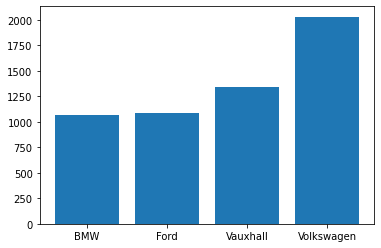

In [19]:
plt.bar(x = score_gr.index,height = score_gr.values)